Карпеченко Д.М., dz14, v.0.2, 16.11.2022

In [402]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler as MMScaler
from sklearn.pipeline import Pipeline


#Снять ограничения на вывод колонок
pd.set_option('display.max_columns', None)
#Снять ограничения на вывод строк
pd.set_option('display.max_rows', 15)
data_train = pd.read_csv(r'D:\TeachMeSkills\DZ\dz14\titanic_train.csv',usecols = ['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked'], sep = ',', encoding='cp1251')
data_test = pd.read_csv(r'D:\TeachMeSkills\DZ\dz14\titanic_test.csv', usecols = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked'], sep = ',', encoding='cp1251')
Y_test = pd.read_csv(r'D:\TeachMeSkills\DZ\dz14\gender_submission.csv',usecols = ['Survived'], sep = ',', encoding='cp1251')

In [403]:
data_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


In [404]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

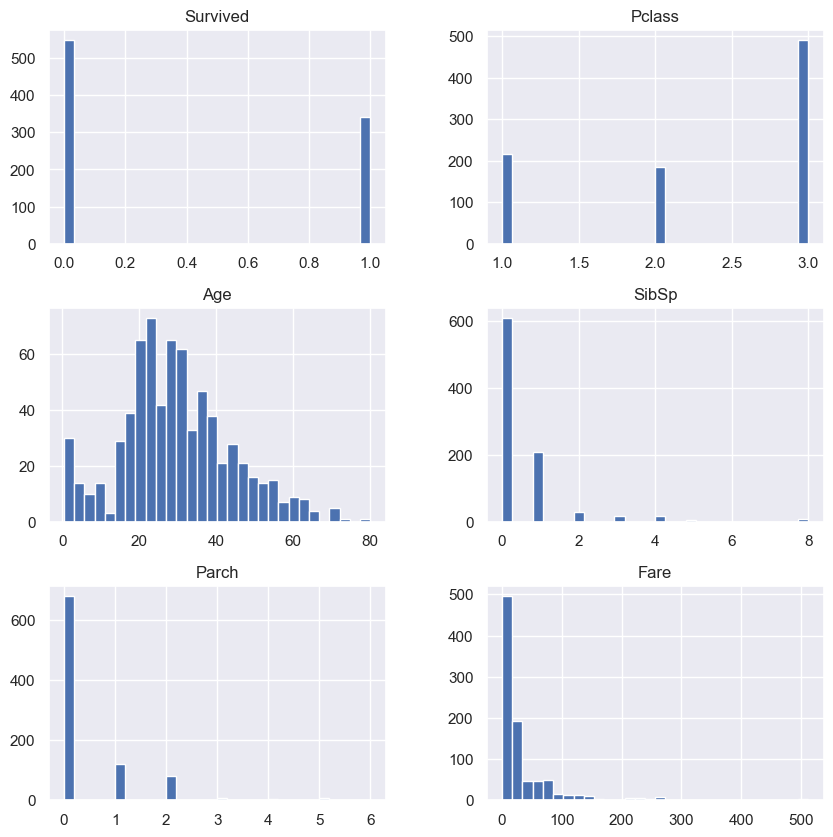

In [405]:
data_train.hist(bins = 30, figsize = (10, 10))

In [406]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Cabin     91 non-null     object 
 7   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


# Заполним пропуски в данных

Для столбца Cabin для nan строк введем новую переменную ZZZ (для сохранения информации). И введем новую колонку с обозначением палубы

In [407]:
data_train.loc[(data_train['Cabin'].isnull()), 'Cabin']='ZZZ'
data_test.loc[(data_test['Cabin'].isnull()), 'Cabin']='ZZZ'

In [408]:
data_train['Pal']=data_train['Cabin'].str[0]
data_test['Pal']=data_test['Cabin'].str[0]

In [409]:
data_train['Pal'].value_counts()

Z    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Pal, dtype: int64

In [410]:
data_train['CFam']=data_train['SibSp']+data_train['Parch']
data_test['CFam']=data_test['SibSp']+data_test['Parch']

In [411]:
data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pal,CFam
0,3,male,34.5,0,0,7.8292,ZZZ,Q,Z,0
1,3,female,47.0,1,0,7.0000,ZZZ,S,Z,1
2,2,male,62.0,0,0,9.6875,ZZZ,Q,Z,0
3,3,male,27.0,0,0,8.6625,ZZZ,S,Z,0
4,3,female,22.0,1,1,12.2875,ZZZ,S,Z,2
...,...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,ZZZ,S,Z,0
414,1,female,39.0,0,0,108.9000,C105,C,C,0
415,3,male,38.5,0,0,7.2500,ZZZ,S,Z,0
416,3,male,NaN,0,0,8.0500,ZZZ,S,Z,0


Для столбца Embarked заменим нпустые значения на мажоритарный признак S

In [412]:
data_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [413]:
data_train.loc[(data_train['Embarked'].isnull()), 'Embarked']='S'

Заменим пропуски в возрасте на среднее значение по полу

In [414]:
import sqlite3
con = sqlite3.connect('db')
data_train.to_sql('titanic_train', con, index=False, if_exists='replace')

891

In [415]:
sql2 = '''select sex,avg(age) as cnt from titanic_train group by Sex'''
graf=pd.read_sql(sql2,con)
graf

,Sex,cnt
0,female,27.915709
1,male,30.726645


In [416]:
data_train.loc[(data_train['Age'].isnull())&(data_train['Sex']=='female'), 'Age']=28
data_train.loc[(data_train['Age'].isnull())&(data_train['Sex']=='male'), 'Age']=31  
data_test.loc[(data_test['Age'].isnull())&(data_test['Sex']=='female'), 'Age']=28
data_test.loc[(data_test['Age'].isnull())&(data_test['Sex']=='male'), 'Age']=31  

Заменим пропуск Fare на среднее значение для класса

In [417]:
data_test.loc[(data_test['Fare'].isnull())]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pal,CFam
152,3,male,60.5,0,0,NaN,ZZZ,S,Z,0


In [418]:
import sqlite3
con1 = sqlite3.connect('db')
data_test.to_sql('titanic_test', con, index=False, if_exists='replace')

418

In [419]:
sql2 = '''select avg(Fare) as cnt from titanic_test where Pclass==3'''
graf=pd.read_sql(sql2,con)
graf

,cnt
0,12.459678


In [420]:
data_test.loc[(data_test['Fare'].isnull()), 'Fare']=12.4597

In [421]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Cabin     418 non-null    object 
 7   Embarked  418 non-null    object 
 8   Pal       418 non-null    object 
 9   CFam      418 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


In [422]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  891 non-null    object 
 9   Pal       891 non-null    object 
 10  CFam      891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Выводы: к счастью пропуски у нас были не в сильно значащих колонках (может кроме Age). Впринципе можно было просто и удалить все пропуски

In [423]:
sql2 = '''select count(sex),Sex,Survived,avg(age) as cnt from titanic_train group by Survived, Sex'''
graf=pd.read_sql(sql2,con)
graf

,count(sex),Sex,Survived,cnt
0,81,female,0,25.046875
1,468,male,0,31.618056
2,233,female,1,28.847716
3,109,male,1,27.276022


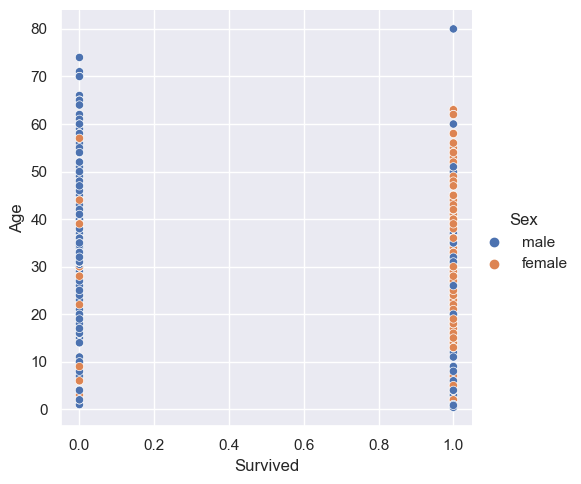

In [424]:
# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=data_train,
    x="Survived", y="Age", hue="Sex"
)

В два раза больше вероятность выживания женщин, чем мужчин

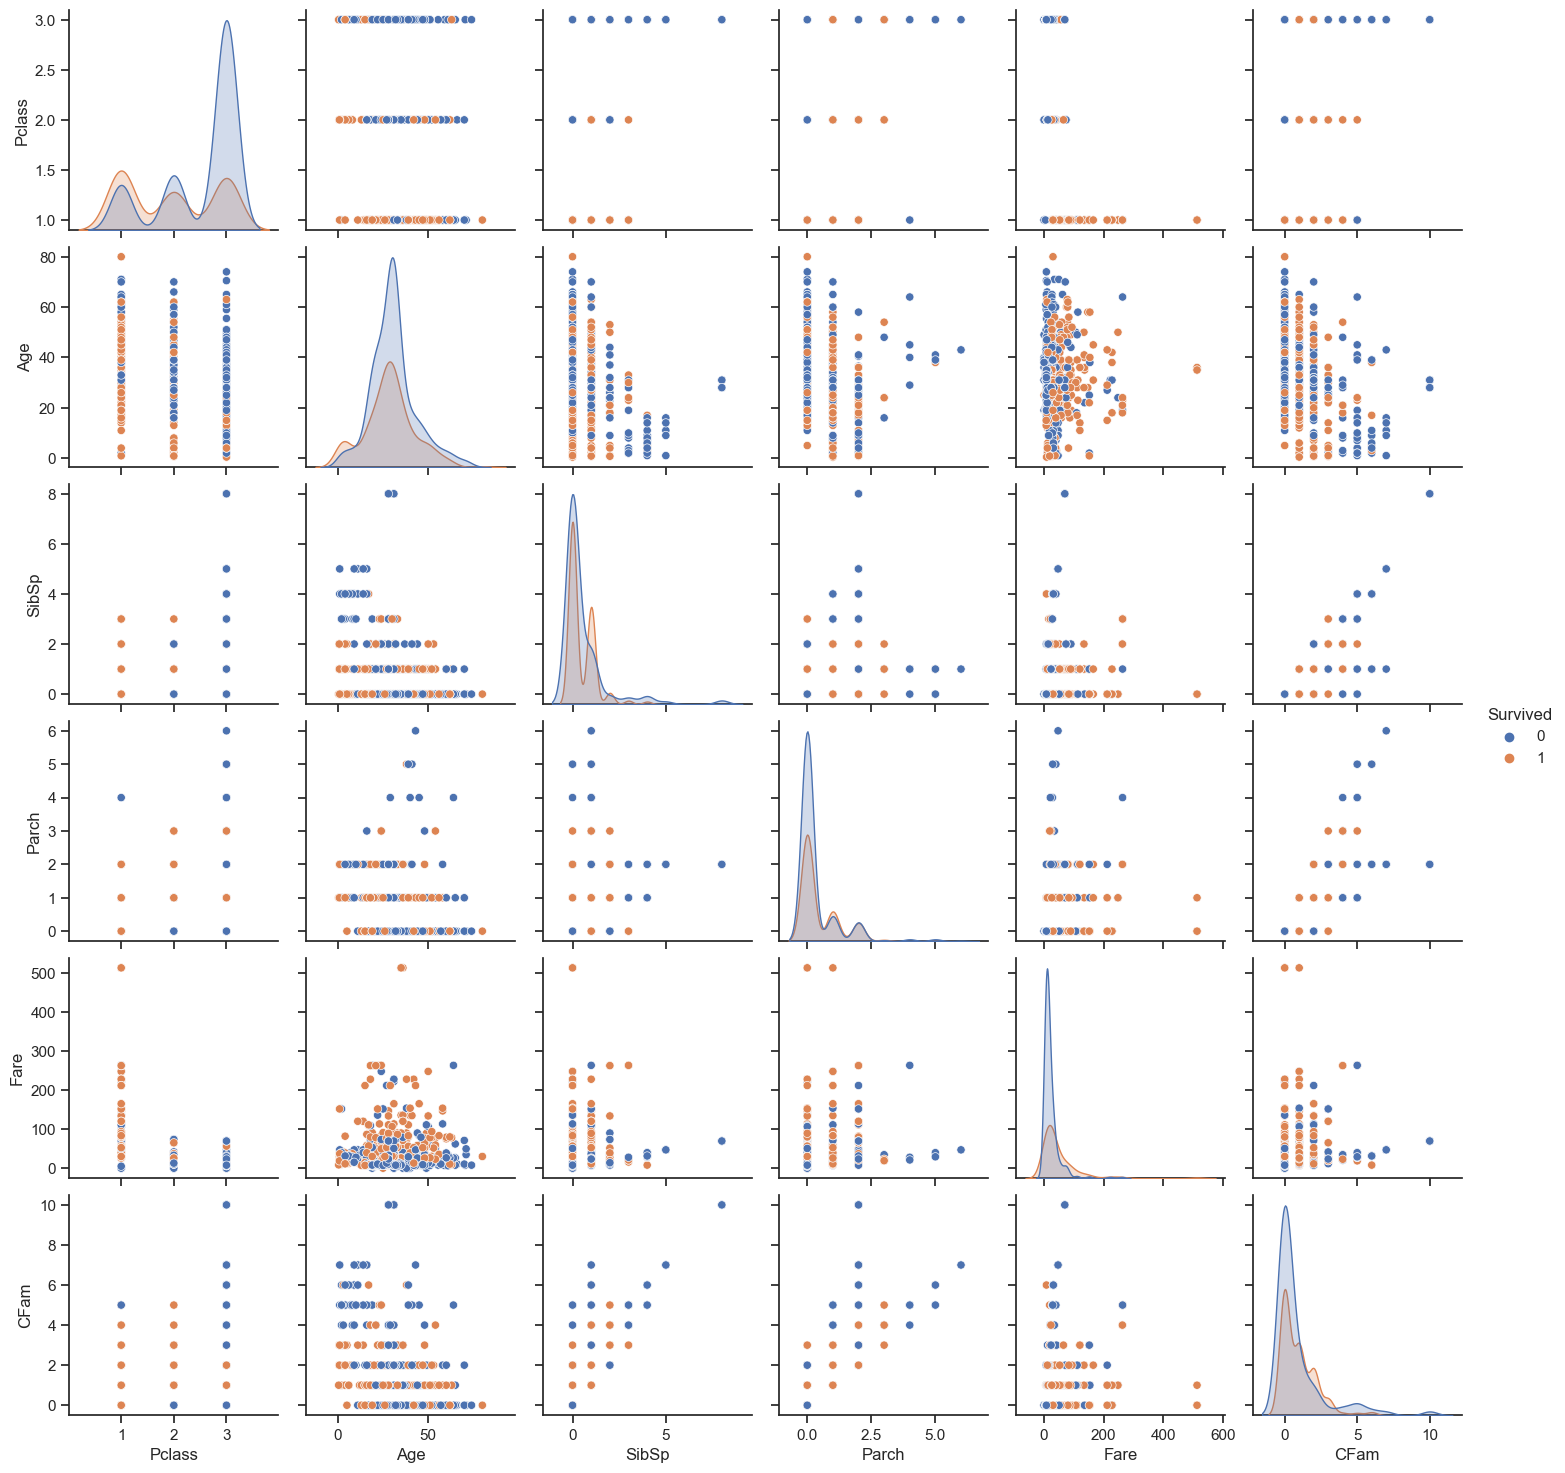

In [425]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(data_train, hue="Survived")

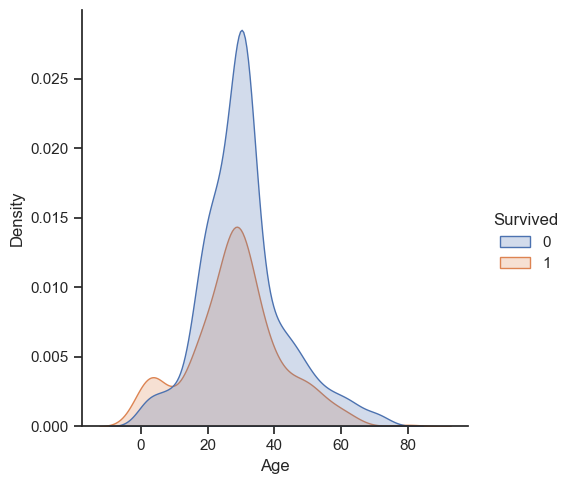

In [426]:
sns.displot(data_train, x="Age", hue="Survived", kind="kde", fill=True)

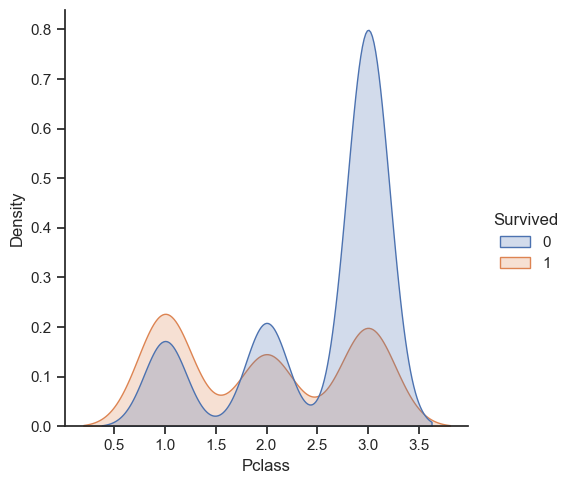

In [427]:
sns.displot(data_train, x="Pclass", hue="Survived", kind="kde", fill=True)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 88.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\envs\My\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 78.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


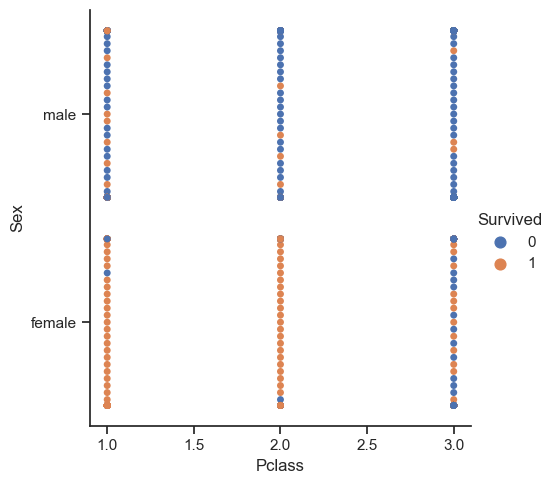

In [428]:
sns.catplot(data=data_train, x="Pclass", y="Sex", hue="Survived", kind="swarm")

Выводы: от возраста выживаемость не зависила. Зависимость прослеживается от пола и, можно предположить, от класса номера (но это не точно)

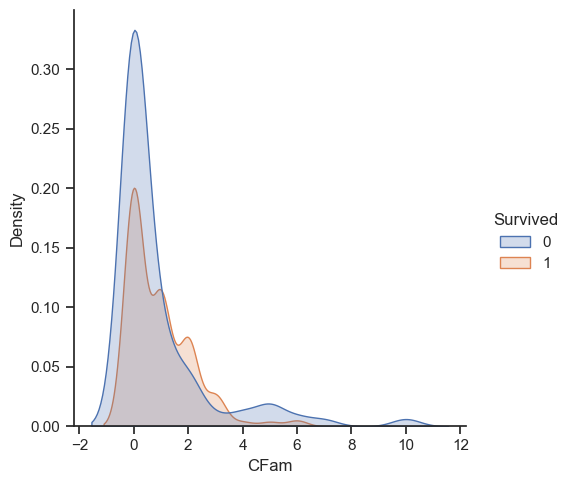

In [429]:
sns.displot(data_train, x="CFam", hue="Survived", kind="kde", fill=True)

Количество членов семьи на выживаемость влияет, если только путешествовали по 2-3 человека,впротивном случае больше вероятность не выжить

In [430]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  891 non-null    object 
 9   Pal       891 non-null    object 
 10  CFam      891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Построим график зависимости номера палубы от класса 

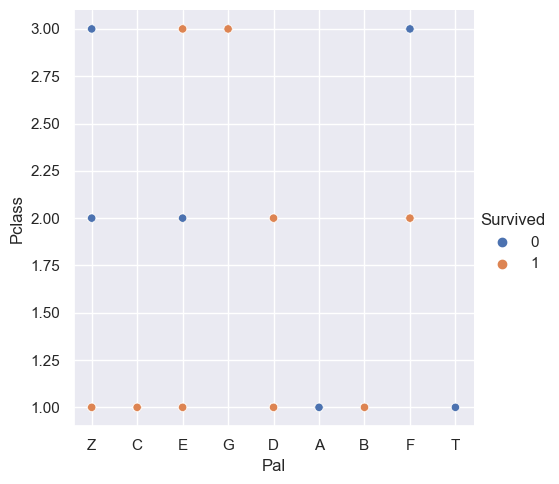

In [431]:
# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=data_train,
    x="Pal", y="Pclass", hue="Survived"
)

Класс номера не зависит от палубы

Проверим как на выживаемость влиял номер палубы

In [432]:
sql2 = '''select count(pal),pal,Survived as cnt from titanic_train group by pal,Survived'''
graf=pd.read_sql(sql2,con)
graf


,count(pal),Pal,cnt
0,8,A,0
1,7,A,1
2,12,B,0
3,35,B,1
4,24,C,0
...,...,...,...
12,2,G,0
13,2,G,1
14,1,T,0
15,481,Z,0


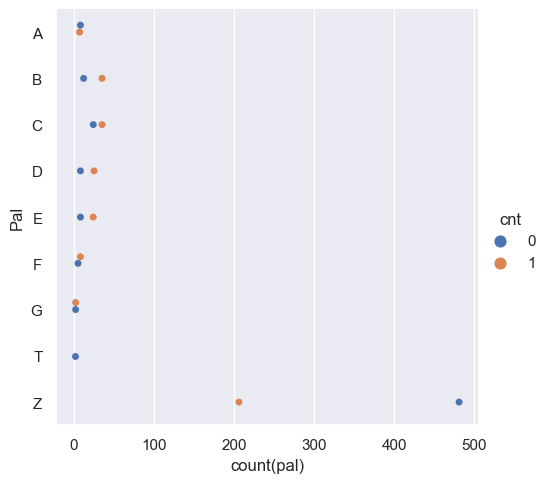

In [433]:
sns.catplot(data=graf, x="count(pal)", y="Pal", hue="cnt", kind="swarm")

На палубе Т нет выживших (если не учитывать класс Z, который мы ввели для пропусков), на палубе G и A  равное отношение спасенных и погибших, на остальных выходит, что спасенных больше, но не на много. 

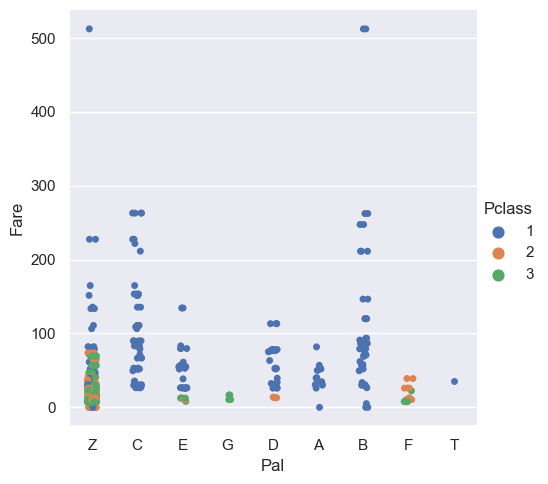

In [434]:
sns.catplot(data=data_train, x="Pal", y="Fare", hue="Pclass")

Как то тяжело найти связь между стоимостью, классом и палубой

In [435]:
data_train.drop(labels=['Cabin'], axis=1, inplace=True)

In [436]:
data_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pal,CFam
0,0,3,male,22.0,1,0,7.2500,S,Z,1
1,1,1,female,38.0,1,0,71.2833,C,C,1
2,1,3,female,26.0,0,0,7.9250,S,Z,0
3,1,1,female,35.0,1,0,53.1000,S,C,1
4,0,3,male,35.0,0,0,8.0500,S,Z,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Z,0
887,1,1,female,19.0,0,0,30.0000,S,B,0
888,0,3,female,28.0,1,2,23.4500,S,Z,3
889,1,1,male,26.0,0,0,30.0000,C,C,0


In [437]:
data_test.drop(labels=['Cabin'], axis=1, inplace=True)

In [438]:
data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pal,CFam
0,3,male,34.5,0,0,7.8292,Q,Z,0
1,3,female,47.0,1,0,7.0000,S,Z,1
2,2,male,62.0,0,0,9.6875,Q,Z,0
3,3,male,27.0,0,0,8.6625,S,Z,0
4,3,female,22.0,1,1,12.2875,S,Z,2
...,...,...,...,...,...,...,...,...,...
413,3,male,31.0,0,0,8.0500,S,Z,0
414,1,female,39.0,0,0,108.9000,C,C,0
415,3,male,38.5,0,0,7.2500,S,Z,0
416,3,male,31.0,0,0,8.0500,S,Z,0


In [439]:
Y_train=data_train.Survived

In [440]:
X_train=data_train.copy()

In [441]:
X_train.drop(labels=['Survived'], axis=1, inplace=True)

In [442]:
X_test=data_test.copy()

In [443]:
X_test['Pal'][0]='T'

C:\Users\HP\AppData\Local\Temp\ipykernel_2456\2196155213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pal'][0]='T'


In [444]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pal,CFam
0,3,male,34.5,0,0,7.8292,Q,T,0
1,3,female,47.0,1,0,7.0000,S,Z,1
2,2,male,62.0,0,0,9.6875,Q,Z,0
3,3,male,27.0,0,0,8.6625,S,Z,0
4,3,female,22.0,1,1,12.2875,S,Z,2
...,...,...,...,...,...,...,...,...,...
413,3,male,31.0,0,0,8.0500,S,Z,0
414,1,female,39.0,0,0,108.9000,C,C,0
415,3,male,38.5,0,0,7.2500,S,Z,0
416,3,male,31.0,0,0,8.0500,S,Z,0


In [445]:
X_train=pd.concat([X_train, 
            pd.get_dummies(X_train['Sex'], prefix='Sex'),
            pd.get_dummies(X_train['Embarked'], prefix='Embarked'),
            pd.get_dummies(X_train['Pal'], prefix='Pal')], axis=1)

In [446]:
X_train=X_train.drop(['Sex','Embarked','Pal'],axis=1)

In [447]:
X_test=pd.concat([X_test, 
            pd.get_dummies(X_test['Sex'], prefix='Sex'),
            pd.get_dummies(X_test['Embarked'], prefix='Embarked'),
            pd.get_dummies(X_test['Pal'], prefix='Pal')], axis=1)

In [448]:
X_test=X_test.drop(['Sex','Embarked','Pal'],axis=1)

In [449]:
X_train

,Pclass,Age,SibSp,Parch,Fare,CFam,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pal_A,Pal_B,Pal_C,Pal_D,Pal_E,Pal_F,Pal_G,Pal_T,Pal_Z
0,3,22.0,1,0,7.2500,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
887,1,19.0,0,0,30.0000,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
888,3,28.0,1,2,23.4500,3,1,0,0,0,1,0,0,0,0,0,0,0,0,1
889,1,26.0,0,0,30.0000,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0


In [450]:
X_test

,Pclass,Age,SibSp,Parch,Fare,CFam,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pal_A,Pal_B,Pal_C,Pal_D,Pal_E,Pal_F,Pal_G,Pal_T,Pal_Z
0,3,34.5,0,0,7.8292,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,3,47.0,1,0,7.0000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,2,62.0,0,0,9.6875,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,3,27.0,0,0,8.6625,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,3,22.0,1,1,12.2875,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,31.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
414,1,39.0,0,0,108.9000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
415,3,38.5,0,0,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
416,3,31.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [476]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [477]:
clf = DecisionTreeClassifier()

In [478]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [479]:
predicted=clf.predict(X_test)

In [480]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,predicted))

0.7918660287081339


In [481]:
grid = {'max_depth': [3, 4, 5]}
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=42), grid, scoring='roc_auc', cv=3, n_jobs=-1)

In [482]:
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5]}, scoring='roc_auc')

In [483]:
gridsearch.best_params_

{'max_depth': 5}

In [484]:
clf = DecisionTreeClassifier(max_depth=3, random_state=42 )
clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [485]:
print(accuracy_score(Y_test,predicted))

0.7918660287081339


In [486]:
clf.feature_importances_

array([0.16083096, 0.07237825, 0.        , 0.        , 0.05187403,
       0.        , 0.64215643, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07276033])

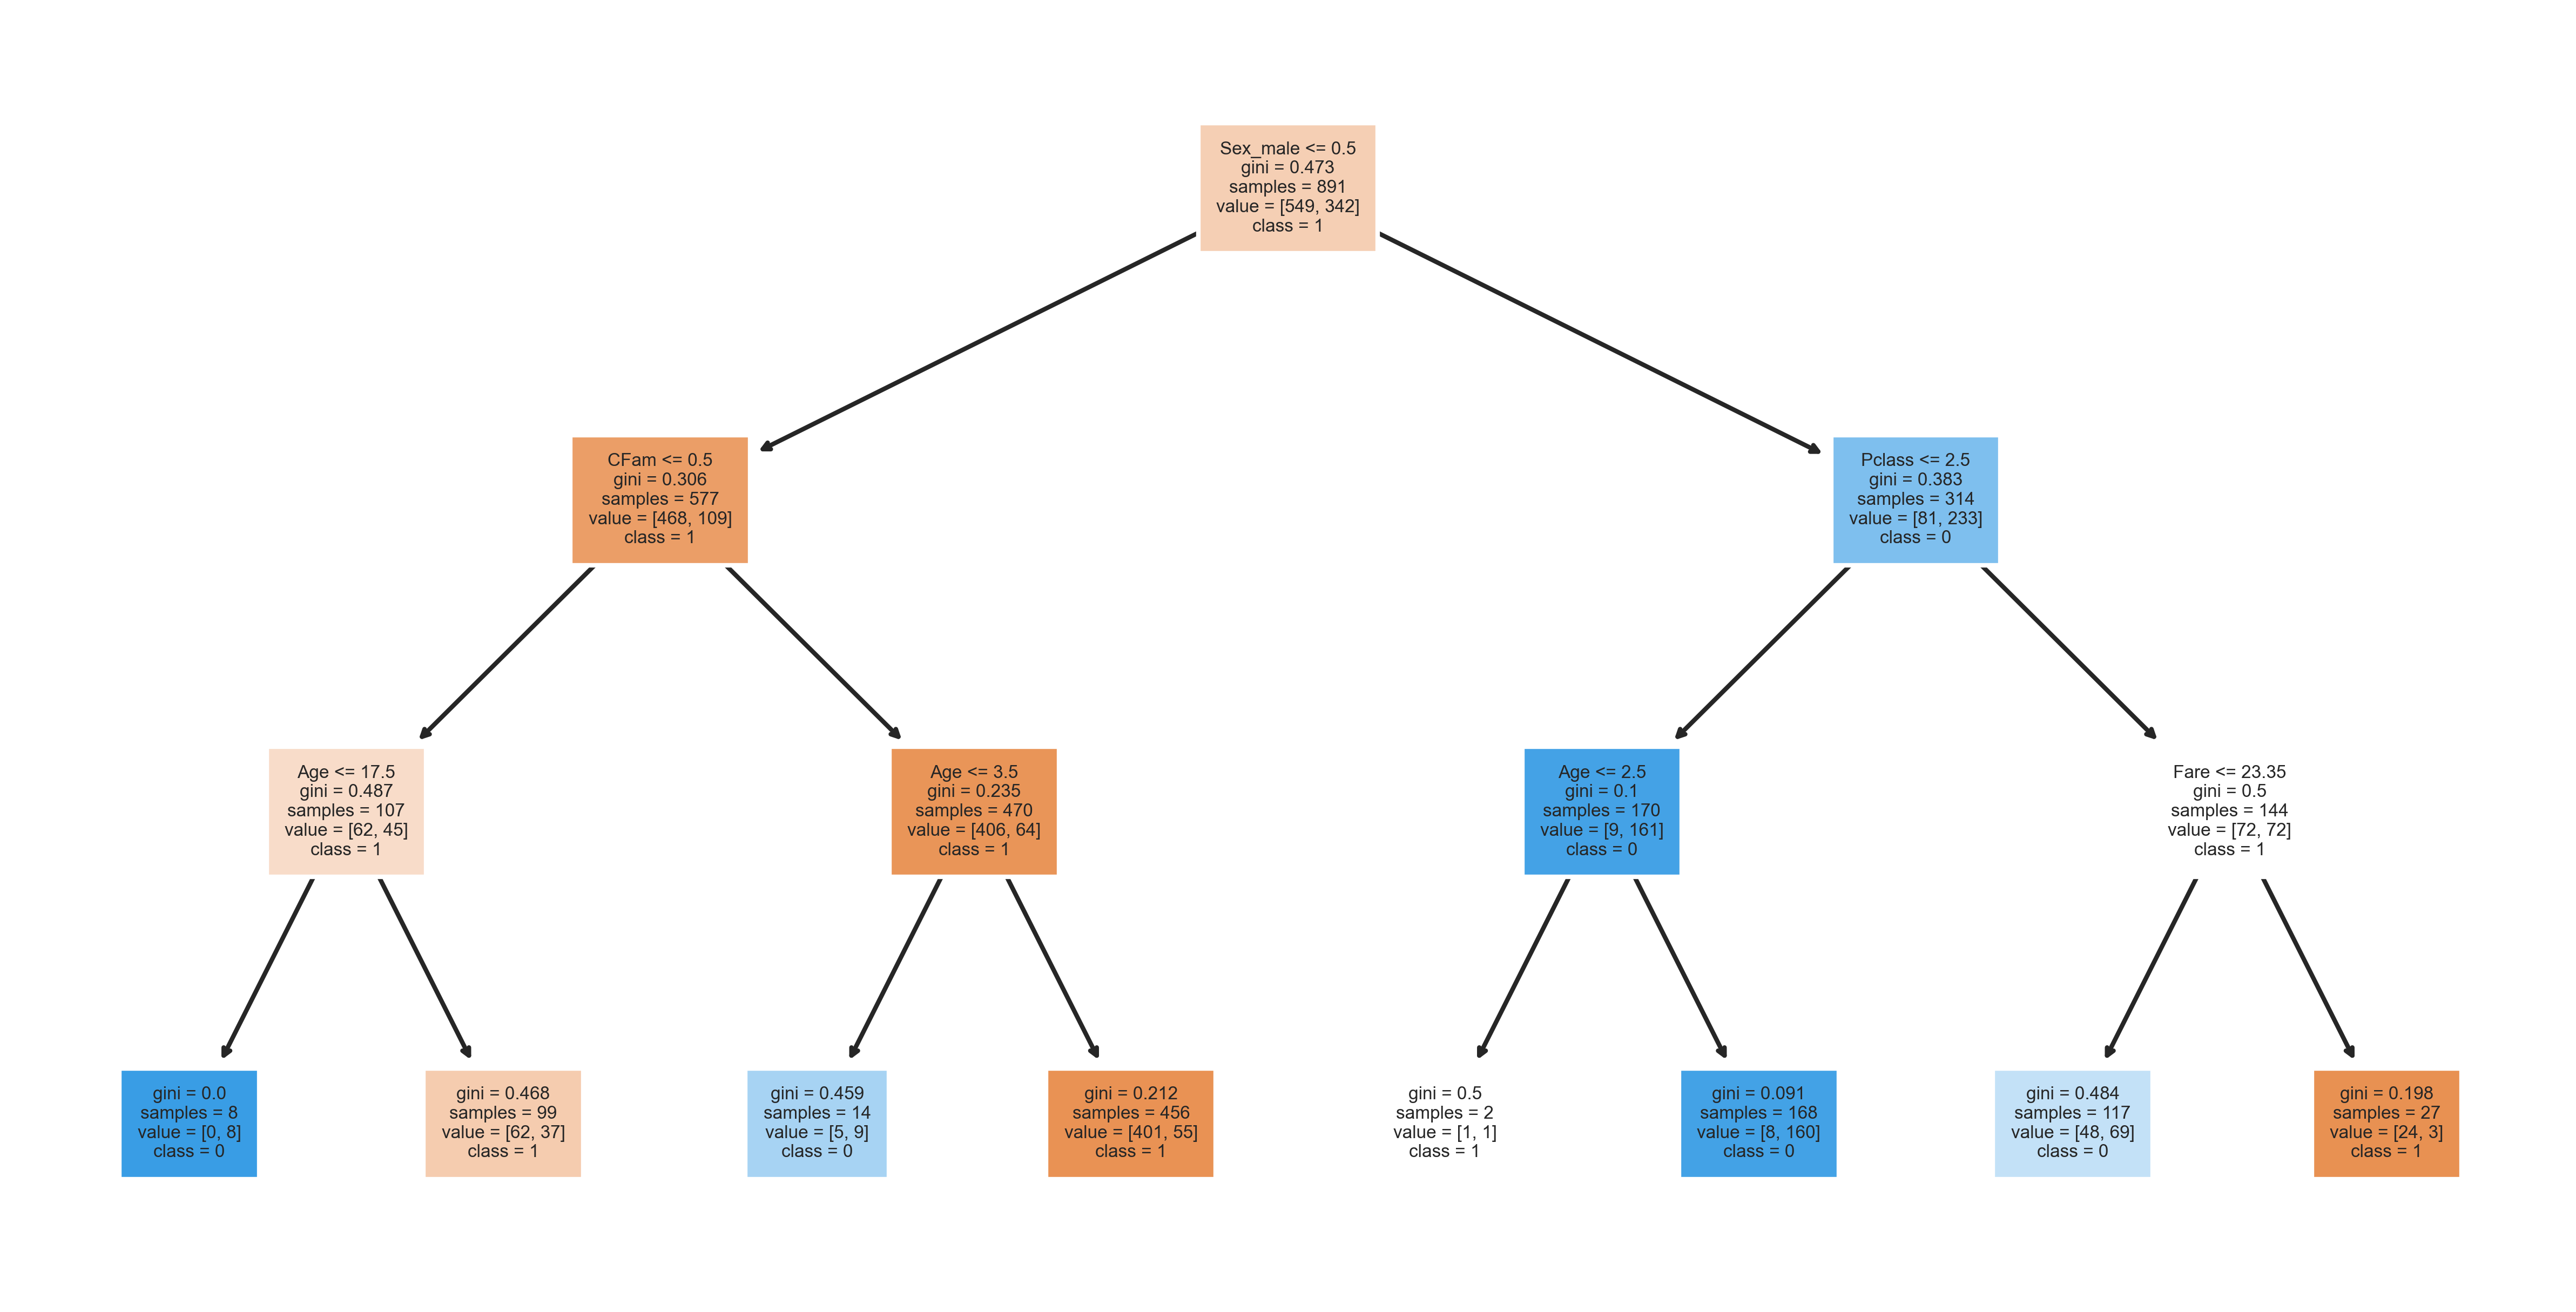

In [487]:
fn=['Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S','Pal_A','Pal_B','Pal_C','Pal_D','Pal_E','Pal_F','Pal_G','Pal_T','Pal_Z','CFam']
cn=['1', '0']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=600)
tree.plot_tree(clf, max_depth=3,
               feature_names = fn, 
               class_names=cn, fontsize=4,
               filled = True);